# Heat maps

In [1]:
from models import VGG16, ResNet21, Transfer_model
from utils import saveFigures,write_json,create_json,load_previous_weights
import tensorflow as tf
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

## Auxiliar functions

In [2]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

In [3]:
def get_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


# Load data

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)

X_train = X_train/255.
X_valid = X_valid/255.
X_test = X_test/255.

num_classes = y_test.shape[1]
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

print("num_training_samples: ", X_train.shape)

num_training_samples:  (40000, 32, 32, 3)


## Define model and load weights

In [5]:
weights_path = Path("weightsTL.h5")

model = Transfer_model(0.1, num_classes=10, img_width=32, img_height=32, img_channels=3,l2_reg=0,batch_norm = True)
model.load_weights(weights_path)
for l in model.layers:
    print(l.name, l.output_shape)

2022-01-19 13:25:22.718022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 13:25:22.718412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 13:25:22.744611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 13:25:22.744999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 13:25:22.745339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

58900480/58889256 [==============================] - 5s 0us/step
input_1 [(None, 32, 32, 3)]
block1_conv1 (None, 32, 32, 64)
block1_conv2 (None, 32, 32, 64)
block1_pool (None, 16, 16, 64)
block2_conv1 (None, 16, 16, 128)
block2_conv2 (None, 16, 16, 128)
block2_pool (None, 8, 8, 128)
block3_conv1 (None, 8, 8, 256)
block3_conv2 (None, 8, 8, 256)
block3_conv3 (None, 8, 8, 256)
block3_pool (None, 4, 4, 256)
block4_conv1 (None, 4, 4, 512)
block4_conv2 (None, 4, 4, 512)
block4_conv3 (None, 4, 4, 512)
block4_pool (None, 2, 2, 512)
block5_conv1 (None, 2, 2, 512)
block5_conv2 (None, 2, 2, 512)
block5_conv3 (None, 2, 2, 512)
block5_pool (None, 1, 1, 512)
batch_normalization (None, 1, 1, 512)
flatten (None, 512)
dropout (None, 512)
dense (None, 512)
dropout_1 (None, 512)
dense_1 (None, 512)
dropout_2 (None, 512)
dense_2 (None, 10)


In [6]:
from sklearn import metrics

y_pred = np.argmax(model.predict(X_test), axis=1)
gt = np.argmax(y_test, axis=1)

# Evaluate predictions: Average accuracy and highest errors
print("-----------------------------------------------")
print("Evaluation:")
# Compute average accuracy
ave_accuracy = metrics.accuracy_score(y_test, y_pred)
print('Average accuracy = ', ave_accuracy)
print("-----------------------------------------------")



2022-01-19 13:25:30.324204: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-01-19 13:25:30.839052: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


-----------------------------------------------
Evaluation:
Average accuracy =  0.8639
-----------------------------------------------


0 5
0 5
1 6
1 6
2 7
2 7
3 8
3 8
4 9
4 9
5 0
5 0
6 1
6 1
7 2
7 2
8 3
8 3
9 4
9 4


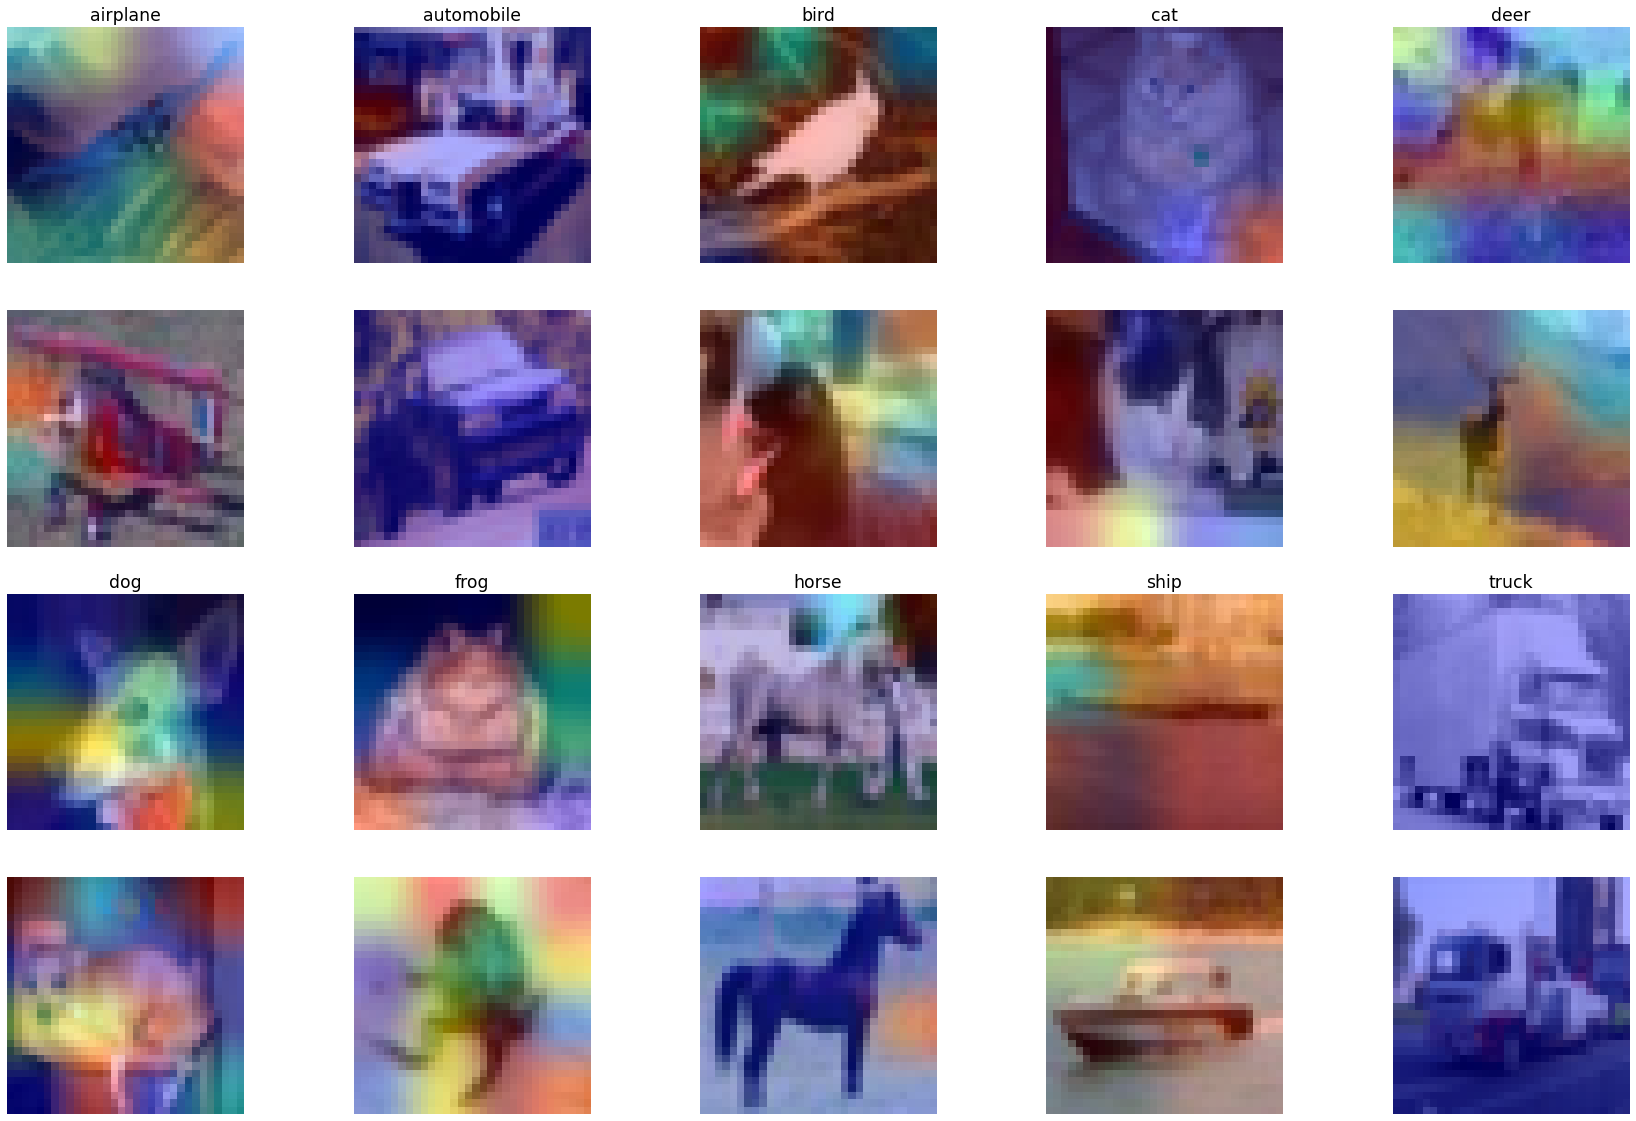

In [16]:
N_class = len(class_names)
N_samples = 2

fig, axs = plt.subplots(N_samples*2 ,N_class//2, figsize=(30,20))

for ax in axs:
    for a in ax:
        a.set_axis_off()

np.random.seed(100)

for label, c in enumerate(class_names):
    idx =  np.random.choice(np.where(y_test[:,0]==label)[0], N_samples )
    for a, i in enumerate(idx):
        img = X_test[i:i+1]
        pred_index = (label+5) % 10
        print(label,pred_index)

        heatmap1 = make_gradcam_heatmap(img, model, "block5_conv3", pred_index=pred_index)
        heatmap2 = make_gradcam_heatmap(img, model, "block4_conv3", pred_index=pred_index)
        
        heatmap1 = tf.repeat(tf.repeat(heatmap1,repeats =2, axis=0),repeats =2, axis=1)

        heatmap = heatmap1+heatmap2

        axs[a+(label//5)*N_samples, label%5].imshow(get_gradcam(img[0], heatmap))
        if a==0:
            axs[a+(label//5)*N_samples, label%5].set_title(c, fontsize="xx-large")
    